# Data Exploration

## Plan

* We'll start with Preprocessing categorical values and applying some standard data cleaning steps.
    * Remove spaces.
    * Convert to lower case.
    * Unicode normalization.
    * Handling missing/unknown categories.
* We'll create `scikit-learn` pipelines that we can reusing during training. 
* We'll do the same for numerical data as well. 
* At the end of this notebook we'll have list of data preparation steps needed to train the model.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

from pathlib import Path

## Read Training Data

In [2]:
## root directory for all data files
data_dir = Path("..", "data")

In [3]:
X_train = pd.read_csv(Path(data_dir,"X_train.csv"))
y_train = pd.read_csv(Path(data_dir,"y_train.csv"))

In [4]:
X_train.shape,y_train.shape

((22320, 16), (22320, 1))

## Preprocessing Categorical Data

In [5]:
## lets list the categorical columns
X_train.select_dtypes(include=["object"]).dtypes

gender               object
city                 object
profession           object
sleep_duration       object
dietary_habits       object
degree               object
suicidal_thoughts    object
family_history       object
dtype: object

In [6]:
## lets look at the data to make sure they are correctly typed as object
X_train.select_dtypes(include=["object"]).head(5)

,gender,city,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,family_history
0,Male,Jaipur,Student,'7-8 hours',Moderate,'Class 12',Yes,No
1,Male,Vadodara,Student,'7-8 hours',Moderate,B.Arch,No,Yes
2,Male,Ahmedabad,Student,'7-8 hours',Unhealthy,M.Ed,Yes,Yes
3,Male,Bhopal,Student,'7-8 hours',Moderate,B.Com,Yes,No
4,Male,Patna,Student,'5-6 hours',Unhealthy,B.Com,No,No


In [7]:
## creating column list for easier access
category_columns = X_train.select_dtypes(include=["object"]).dtypes.index.tolist()
category_columns

['gender',
 'city',
 'profession',
 'sleep_duration',
 'dietary_habits',
 'degree',
 'suicidal_thoughts',
 'family_history']

### Default Changes
* This section applies all the default changes to categorical data like, 
    * removing spaces, 
    * replacing empty string with unknown (we can use some kind of prediction algorithm here but for now unknown is good since there are no empty values. )
    * lower case the values.
    * Unicode normalizer 

In [8]:
## lets check for missing values
X_train.select_dtypes(include=["object"]).isnull().sum()

gender               0
city                 0
profession           0
sleep_duration       0
dietary_habits       0
degree               0
suicidal_thoughts    0
family_history       0
dtype: int64

Luckily there are no missing values but our training pipeline should have a step to fill missing values with "unkonwn" in case production data or test data has missing values. 

In [9]:
## TODO Add this to pipeline
X_train.select_dtypes(include=["object"]).fillna("unknown", inplace=True)

Lets create pipelines to transform the data for easy exploration.

In [10]:
import unicodedata
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from pandas.api.types import is_string_dtype

## creating functional transformers

## fill na with Unknown
def fill_empty_strings_fn(df, columns=None):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    for col in df_copy.columns:
        ## TODO : Confirm if comparing with type object is correct. 
        if is_string_dtype(df_copy[col]):
            df_copy[col] = df_copy[col].fillna("unknown")
    return df_copy

## remove spaces
def strip_spaces_fn(df, colmns=None):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    for col in df_copy.columns:
        ## TODO : Confirm if comparing with type object is correct. 
        if is_string_dtype(df_copy[col]):
            df_copy[col] = df_copy[col].str.strip()
    return df_copy



def to_lower_case_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    for col in df_copy.columns:
        ## TODO : Confirm if comparing with type object is correct. 
        if is_string_dtype(df_copy[col]):
            df_copy[col] = df_copy[col].str.lower()
    return df_copy

def normalize_unicode_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    for col in df_copy.columns:
        ## TODO : Confirm if comparing with type object is correct. 
        if is_string_dtype(df_copy[col]):
            df_copy[col] = df_copy[col].map(lambda ct: unicodedata.normalize("NFKD",ct).encode("ascii","ignore").decode())
    return df_copy


fill_empty_strings = FunctionTransformer(fill_empty_strings_fn,feature_names_out="one-to-one")
strip_spaces = FunctionTransformer(strip_spaces_fn,feature_names_out="one-to-one")
to_lower_case = FunctionTransformer(to_lower_case_fn,feature_names_out="one-to-one")
normalize_unicode = FunctionTransformer(normalize_unicode_fn, feature_names_out="one-to-one")

In [11]:
## in our use case pipeline would make more sense as we need to use output of one transformer in another. 
default_cat_pipeline = Pipeline([
    ("fill_empty_strings", fill_empty_strings),
    ("strip_spaces", strip_spaces),
    ("to_lower_case", to_lower_case),
    ("normalize_unicode", normalize_unicode)    
], )

## only run the pipeline on categorical data
updated_categories = default_cat_pipeline.fit_transform(X_train.select_dtypes(include=["object", "string"]))
updated_categories.head()

,gender,city,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,family_history
0,male,jaipur,student,'7-8 hours',moderate,'class 12',yes,no
1,male,vadodara,student,'7-8 hours',moderate,b.arch,no,yes
2,male,ahmedabad,student,'7-8 hours',unhealthy,m.ed,yes,yes
3,male,bhopal,student,'7-8 hours',moderate,b.com,yes,no
4,male,patna,student,'5-6 hours',unhealthy,b.com,no,no


### Preprocessing Gender Column

In [12]:
updated_categories["gender"].value_counts()

gender
male      12437
female     9883
Name: count, dtype: int64

* Since the data is distributed between just 2 genders we can use `OneHotEncoder` to encode the data.
* Lets also use this to explore how we'll design our design our data transformation implementation. We'll need a combination of Pipelines and ColumnTransformers to make it efficient. 

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


gender_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("encode_gender", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocess_gender = ColumnTransformer([
    ("preprocess_gender", gender_pipeline, ["gender"])
])

preprocess_gender.fit_transform(X_train)
preprocess_gender.get_feature_names_out()

array(['preprocess_gender__gender_female',
       'preprocess_gender__gender_male'], dtype=object)

* So this will be our plan going forward, we'll create column specific pipelines which will be a combination of default pipeline and column specific transformations and finally combine all pipeline into one clean "preprocess_pipeline" column transformer. 
* For now we'll keep gender as it is for easier data exploration in next section. 

### Preprocessing Profession Column

In [14]:
updated_categories["profession"].value_counts()

profession
student                     22294
architect                       6
teacher                         4
'digital marketer'              3
'content writer'                2
chef                            2
doctor                          2
pharmacist                      2
manager                         1
'educational consultant'        1
lawyer                          1
entrepreneur                    1
'civil engineer'                1
Name: count, dtype: int64

In [15]:
(updated_categories[updated_categories["profession"] != 'student'].shape[0] / updated_categories.shape[0] ) * 100

0.11648745519713263

* So majority of the profession are students, and we have less than 1% of non student instances.
* Although this lack of variance will contribute very little to our classification, for now we'll create a pipeline to change value of every non-student to 'working' and then one-hot encode them. 
* This assumption might be wrong in test data or in production, but we'll handle it when we see new information. 

In [16]:
# function to map "profession" column values to 'student' and 'working'
def map_working_profession_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy.loc[df_copy["profession"] != 'student'] = 'working'
    return df_copy

map_working_profession = FunctionTransformer(map_working_profession_fn, feature_names_out="one-to-one")

profession_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("map_profession", map_working_profession),
    ("encode_profession", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocess_profession = ColumnTransformer([
    ("preprocess_profession", profession_pipeline, ["profession"])
])

# we can uncomment this if we need pandas as output
# preprocess_profession.set_output(transform="pandas")

temp = preprocess_profession.fit_transform(X_train)
preprocess_profession.get_feature_names_out()


array(['preprocess_profession__profession_student',
       'preprocess_profession__profession_working'], dtype=object)

* Lets also update the train set for now, to help with data exploration

In [17]:
updated_categories.loc[updated_categories["profession"] != 'student','profession'] = "working"

In [18]:
updated_categories["profession"].value_counts()

profession
student    22294
working       26
Name: count, dtype: int64

### Preprocessing Sleep Duration

In [19]:
updated_categories["sleep_duration"].value_counts()

sleep_duration
'less than 5 hours'    6646
'7-8 hours'            5871
'5-6 hours'            4963
'more than 8 hours'    4825
others                   15
Name: count, dtype: int64

In [20]:
(updated_categories[updated_categories["sleep_duration"] == 'others'].shape[0] / updated_categories.shape[0]) * 100

0.06720430107526883

* Looking at the data I think its safe to merge 'others' with 'more than 8 hours'. 
* Here is the plan,
    * We'll change the values to `lt_5`, `bt_7_8` and `gt_8` so less verbose values and column names. We might find more values in test or prod, but for now we'll assume these are the possible values. 
    * We'll merge `others` to `gt_8` since the sample size is very small.
    * We'll either one hot encode the data or ordinal encoding depending on the algorithm we want to use
* One more interesting thing that we missed earlier is that these strings have single quote in them, we'll need to strip them before processing anything


In [21]:
# helper function to rename and map the sleep duration category
from sklearn.preprocessing import OrdinalEncoder


def clean_sleep_duration_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy["sleep_duration"] = df["sleep_duration"].str.strip("'")
    return df_copy


clean_sleep_duration = FunctionTransformer(
    clean_sleep_duration_fn, feature_names_out="one-to-one")


def map_sleep_duration_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    # map 'less than 5 hours' to lt_5
    df_copy.loc[df_copy["sleep_duration"] ==
                'less than 5 hours', 'sleep_duration'] = 'lt_5'
    # map '5-6 hours' to bt_5_6
    df_copy.loc[df_copy["sleep_duration"] ==
                '5-6 hours', 'sleep_duration'] = 'bt_5_6'
    # map '7-8 hours' to bt_7_8
    df_copy.loc[df_copy["sleep_duration"] ==
                '7-8 hours', 'sleep_duration'] = 'bt_7_8'
    # more than 8 hours to gt_8
    df_copy.loc[df_copy["sleep_duration"] ==
                'more than 8 hours', 'sleep_duration'] = 'gt_8'
    # more than others to gt_8
    df_copy.loc[df_copy["sleep_duration"] ==
                'others', 'sleep_duration'] = 'gt_8'
    return df_copy


map_sleep_duration = FunctionTransformer(
    map_sleep_duration_fn, feature_names_out="one-to-one")


def make_sleep_duration_pipeline_fn(encoding="onehot"):
    steps = [("default_cat_pipeline", default_cat_pipeline),
             ("sleep_duration_clean", clean_sleep_duration),
             ("sleep_duration_mapping", map_sleep_duration)]

    if encoding == "onehot":
        steps.append(("encoder", OneHotEncoder(
            sparse_output=False, handle_unknown="ignore")))
    elif encoding == "ordinal":
        steps.append(("encoder", OrdinalEncoder(categories=[[
            "lt_5", "bt_5_6", "bt_7_8", "gt_8"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)))
    else:
        raise ValueError("Invalid encoding type: choose 'onehot' or 'ordinal'")
    return Pipeline(steps=steps)


preprocess_sleep_duration = ColumnTransformer([(
    "sleep_duration_pipeline", make_sleep_duration_pipeline_fn(encoding="ordinal"), [
        "sleep_duration"]
)])

temp = preprocess_sleep_duration.fit_transform(X_train)
preprocess_sleep_duration.get_feature_names_out()

array(['sleep_duration_pipeline__sleep_duration'], dtype=object)

* Lets update our dataset with cleaned categorical values for easier data exploration later

In [22]:
updated_categories = clean_sleep_duration_fn(updated_categories)
updated_categories = map_sleep_duration_fn(updated_categories)
updated_categories

,gender,city,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,family_history
0,male,jaipur,student,bt_7_8,moderate,'class 12',yes,no
1,male,vadodara,student,bt_7_8,moderate,b.arch,no,yes
2,male,ahmedabad,student,bt_7_8,unhealthy,m.ed,yes,yes
3,male,bhopal,student,bt_7_8,moderate,b.com,yes,no
4,male,patna,student,bt_5_6,unhealthy,b.com,no,no
...,...,...,...,...,...,...,...,...
22315,male,kolkata,student,bt_7_8,unhealthy,b.com,yes,no
22316,female,patna,student,lt_5,unhealthy,msc,yes,yes
22317,male,lucknow,student,bt_7_8,healthy,b.arch,yes,yes
22318,female,kolkata,student,bt_5_6,unhealthy,md,yes,no


### Preprocessing Dietary Habits

In [23]:
updated_categories["dietary_habits"].value_counts()

dietary_habits
unhealthy    8265
moderate     7898
healthy      6149
others          8
Name: count, dtype: int64

* This looks straight forward, we can OneHot/Ordinal encoder to encode them 
* Even here we can merge `other` with `unhealthy` since the sample size is very small

In [24]:
# helper function to map dietary habits 'other' value to unhealthy
def map_dietary_habits_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy.loc[df_copy["dietary_habits"] == "others","dietary_habits"] = "unhealthy"
    return df_copy


map_dietary_habits = FunctionTransformer(
    map_dietary_habits_fn, feature_names_out="one-to-one")


def make_dietary_habits_pipeline_fn(encoding='onehot'):
    steps = [
        ("default_cat_pipeline", default_cat_pipeline),
        ("dietary_habits_mapping", map_dietary_habits)
    ]

    if encoding == "onehot":
        steps.append(("encoder", OneHotEncoder(
            sparse_output=False, handle_unknown="ignore")))
    elif encoding == "ordinal":
        steps.append(("encoder", OrdinalEncoder(categories=[[
            "unhealthy", "moderate", "healthy"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)))
    else:
        raise ValueError("Invalid encoding type: choose 'onehot' or 'ordinal'")
    return Pipeline(steps=steps)

preprocess_dietary_habits = ColumnTransformer([(
    "dietary_habits_pipeline", make_dietary_habits_pipeline_fn(encoding="onehot"), [
        "dietary_habits"]
)])

temp = preprocess_dietary_habits.fit_transform(X_train)
preprocess_dietary_habits.get_feature_names_out()

array(['dietary_habits_pipeline__dietary_habits_healthy',
       'dietary_habits_pipeline__dietary_habits_moderate',
       'dietary_habits_pipeline__dietary_habits_unhealthy'], dtype=object)

* Lets update the category values for exploration

In [25]:
updated_categories = map_dietary_habits_fn(updated_categories)
updated_categories["dietary_habits"].value_counts()

dietary_habits
unhealthy    8273
moderate     7898
healthy      6149
Name: count, dtype: int64

### Preprocessing Degree 

In [26]:
updated_categories["degree"].value_counts()

degree
'class 12'    4808
b.ed          1487
b.com         1193
b.arch        1183
bca           1132
msc            968
b.tech         931
mca            830
m.tech         816
bhm            743
bsc            719
m.ed           672
b.pharm        654
m.com          590
bba            563
mbbs           562
llb            529
be             485
m.pharm        478
ba             477
md             473
mba            455
ma             445
phd            432
llm            380
me             143
mhm            142
others          30
Name: count, dtype: int64

* This is going to be a tricky one, but thanks to ChatGPT we have a dictionary mapping degree to field and level. 
* Here is the plan for the pipeline,
    * Step 1: Clean the values which might have "'" around them .
    * Step 2: Create two new fields degree_field and degree_level and update the values based on dictionary mapping below. We'll also use this for data exploration
    * Step 3: Create a one hot encoding function degree_field
    * Step 4: Create a generic encoding function (one hot or ordinal) for degree level (unknown < high_school < bachelor < master < doctorate). Anything else is -1

In [27]:
degree_mapping_dict = {
    "class 12":     {"field": "school",      "level": "high_school"},

    # Commerce & Business
    "b.com":        {"field": "commerce",    "level": "bachelor"},
    "m.com":        {"field": "commerce",    "level": "master"},
    "bba":          {"field": "business",    "level": "bachelor"},
    "mba":          {"field": "business",    "level": "master"},

    # Engineering & Tech
    "b.tech":       {"field": "engineering", "level": "bachelor"},
    "be":           {"field": "engineering", "level": "bachelor"},
    "b.arch":       {"field": "architecture","level": "bachelor"},
    "me":           {"field": "engineering", "level": "master"},
    "m.tech":       {"field": "engineering", "level": "master"},

    # Science & CS
    "bsc":          {"field": "science",     "level": "bachelor"},
    "msc":          {"field": "science",     "level": "master"},
    "bca":          {"field": "computer_app","level": "bachelor"},
    "mca":          {"field": "computer_app","level": "master"},

    # Education
    "b.ed":         {"field": "education",   "level": "bachelor"},
    "m.ed":         {"field": "education",   "level": "master"},

    # Medical
    "mbbs":         {"field": "medical",     "level": "bachelor"},
    "md":           {"field": "medical",     "level": "master"},  # Technically PG, but aligned here
    "b.pharm":      {"field": "pharmacy",    "level": "bachelor"},
    "m.pharm":      {"field": "pharmacy",    "level": "master"},

    # Law
    "llb":          {"field": "law",         "level": "bachelor"},
    "llm":          {"field": "law",         "level": "master"},

    # Hospitality
    "bhm":          {"field": "hospitality", "level": "bachelor"},
    "mhm":          {"field": "hospitality", "level": "master"},

    # Arts
    "ba":           {"field": "arts",        "level": "bachelor"},
    "ma":           {"field": "arts",        "level": "master"},

    # Research
    "phd":          {"field": "research",    "level": "doctorate"},

    # Other
    "others":       {"field": "unknown",     "level": "unknown"}
}

In [28]:
# helper function to clean up degree column
def clean_degree_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError(
            "degree_clean_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy["degree"] = df_copy["degree"].str.strip("'")
    return df_copy


clean_degree = FunctionTransformer(
    clean_degree_fn, feature_names_out="one-to-one")


def map_degree_feature_names(function_transformer, feature_names_in):
    features_out = feature_names_in.tolist()
    features_out.extend(["degree_field", "degree_level"])
    return features_out

# helper funtion to map degree to degree_field and degree_level
def map_field(val):
    return degree_mapping_dict.get(val, {}).get("field", "unknown")

def map_level(val):
    return degree_mapping_dict.get(val, {}).get("level", "unknown")


def map_degree_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("degree_mapping_fn: Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy["degree_field"] = df_copy["degree"].map(map_field)
    df_copy["degree_level"] = df_copy["degree"].map(map_level)
    return df_copy


map_degree = FunctionTransformer(
    map_degree_fn, feature_names_out=map_degree_feature_names)

# helper function to create a column transformer to encode degree_field and degree_level fields.


def make_degree_encoder(encoding="onehot"):
    degree_level_encoder = OneHotEncoder(
        handle_unknown="ignore", sparse_output=False)
    
    if encoding == "ordinal":
        degree_level_encoder = OrdinalEncoder(categories=[[
            "unknown", "high_school", "bachelor", "master", "doctorate"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)

    return ColumnTransformer([
        ("encode_degree_field", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["degree_field"]),
        ("encode_degree_level", degree_level_encoder, ["degree_level"])
    ])


# testing basic pipeline
degree_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("clean", clean_degree),
    ("mapping", map_degree),
    ("encode_degree",make_degree_encoder())
])

preprocess_degree = ColumnTransformer([
    ("degree_pipeline", degree_pipeline, ["degree"])
])
temp = preprocess_degree.fit_transform(X_train)
preprocess_degree.get_feature_names_out()

array(['degree_pipeline__encode_degree_field__degree_field_architecture',
       'degree_pipeline__encode_degree_field__degree_field_arts',
       'degree_pipeline__encode_degree_field__degree_field_business',
       'degree_pipeline__encode_degree_field__degree_field_commerce',
       'degree_pipeline__encode_degree_field__degree_field_computer_app',
       'degree_pipeline__encode_degree_field__degree_field_education',
       'degree_pipeline__encode_degree_field__degree_field_engineering',
       'degree_pipeline__encode_degree_field__degree_field_hospitality',
       'degree_pipeline__encode_degree_field__degree_field_law',
       'degree_pipeline__encode_degree_field__degree_field_medical',
       'degree_pipeline__encode_degree_field__degree_field_pharmacy',
       'degree_pipeline__encode_degree_field__degree_field_research',
       'degree_pipeline__encode_degree_field__degree_field_school',
       'degree_pipeline__encode_degree_field__degree_field_science',
       'degree_pip

* Lets clean and create the degree mapping columns for data exploration

In [29]:
updated_categories = clean_degree_fn(updated_categories)
updated_categories = map_degree_fn(updated_categories)
updated_categories.head()

,gender,city,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,family_history,degree_field,degree_level
0,male,jaipur,student,bt_7_8,moderate,class 12,yes,no,school,high_school
1,male,vadodara,student,bt_7_8,moderate,b.arch,no,yes,architecture,bachelor
2,male,ahmedabad,student,bt_7_8,unhealthy,m.ed,yes,yes,education,master
3,male,bhopal,student,bt_7_8,moderate,b.com,yes,no,commerce,bachelor
4,male,patna,student,bt_5_6,unhealthy,b.com,no,no,commerce,bachelor


### Preprocessing Suicidal Thoughts Column

In [30]:
updated_categories["suicidal_thoughts"].value_counts()

suicidal_thoughts
yes    14133
no      8187
Name: count, dtype: int64

* This seems straight forward, and data seems clean enough. We can simply one hot encode this column

In [31]:
suicidal_thoughts_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("suididal_thoughts_encoding", OneHotEncoder(
        handle_unknown="ignore", sparse_output=False))
])

preprocess_suicidal_thoughts = ColumnTransformer(
    [(
        "suicidal_thoughts_pipeline", suicidal_thoughts_pipeline,["suicidal_thoughts"]
    )]
)

temp = preprocess_suicidal_thoughts.fit_transform(X_train)
preprocess_suicidal_thoughts.get_feature_names_out()

array(['suicidal_thoughts_pipeline__suicidal_thoughts_no',
       'suicidal_thoughts_pipeline__suicidal_thoughts_yes'], dtype=object)

### Preprocessing Family History

In [32]:
updated_categories["family_history"].value_counts()

family_history
no     11517
yes    10803
Name: count, dtype: int64

* Even this seems straight forward a simple one hot encoding should make this column ready for training. 

In [33]:
family_history_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("family_history_encoding", OneHotEncoder(
        handle_unknown="ignore", sparse_output=False))
])

preprocess_family_history = ColumnTransformer(
    [(
        "family_history_pipeline", family_history_pipeline,["family_history"]
    )]
)

temp = preprocess_family_history.fit_transform(X_train)
preprocess_family_history.get_feature_names_out()

array(['family_history_pipeline__family_history_no',
       'family_history_pipeline__family_history_yes'], dtype=object)

### Preprocessing 'city' column

In [34]:
updated_categories["city"].value_counts()

city
kalyan                  1284
srinagar                1073
hyderabad               1063
vasai-virar             1042
lucknow                  943
thane                    910
kolkata                  890
agra                     864
ludhiana                 848
surat                    842
jaipur                   840
patna                    823
visakhapatnam            763
pune                     751
bhopal                   748
ahmedabad                748
chennai                  707
meerut                   660
rajkot                   633
bangalore                625
delhi                    602
ghaziabad                588
mumbai                   563
vadodara                 561
varanasi                 550
nagpur                   533
indore                   519
kanpur                   493
nashik                   452
faridabad                381
harsha                     2
bhavna                     2
saanvi                     2
city                       2
khaziabad

* So city column needs some clearning, 
    * There might be cities with special characters "'" that needs to be cleaned up.
    * There are some values which are obviously not a city but rather distances, person names and education degree names. To fix this we'll use the master city dataset that has verified city names and lat/long info that we'll add as additional columns
    * We'll also add a `is_valid_city` flag and for in valid city names we'll use `Nagpur` as default name and default lat/long as it is considered to be the geographical center of India. 
    * We don't need encoding for the city but rather we'll use cluster similarity to find the similarity between clusters. We **might** do that after some data exploration.  


In [35]:
## load the master city data
## read master city list
master_city_list = pd.read_csv(Path(data_dir,"detailed_in.csv"))


## convert the city names to lower case
# master_city_list["name"] = master_city_list["name"].str.strip().str.lower()
# master_city_list["ascii_name"] = master_city_list["ascii_name"].str.strip().str.lower()

# ## unicode normalization
# master_city_list["name"] = master_city_list["name"].map(lambda ct: unicodedata.normalize("NFKD",ct).encode("ascii","ignore").decode())
# master_city_list["ascii_name"] = master_city_list["ascii_name"].map(lambda ct: unicodedata.normalize("NFKD",ct).encode("ascii","ignore").decode())

# X_train["city"].map(lambda ct: unicodedata.normalize("NFKD",ct).encode("ascii","ignore").decode())
# master_cities = master_city_list["ascii_name"].str.strip().str.lower().to_list()
# master_cities[:5]
master_city_list.head()

,name,ascii_name,lat,long
0,#100 bed and breakfast,#100 bed and breakfast,12.98332,77.58427
1,10 calangute,10 calangute,15.54244,73.76279
2,100 feet hospital,100 feet hospital,19.38609,72.82558
3,12th avenue hotel,12th avenue hotel,12.97044,77.64617
4,1589 city mark hotel,1589 city mark hotel,28.46348,77.03176


In [36]:
master_city_list["ascii_name"].value_counts()

ascii_name
#100 bed and breakfast    1
narayanpur mardan         1
narayanpur majhari        1
narayanpur main canal     1
narayanpur mafi           1
                         ..
gyadal gondi              1
gya                       1
gwinai                    1
gwilani                   1
zuvvigunta                1
Name: count, Length: 407781, dtype: int64

In [37]:
# helper function to clean up city column and remove special characters
def clean_city_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError(
            "degree_clean_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy["city"] = df_copy["city"].str.strip("'")
    return df_copy

clean_city = FunctionTransformer(clean_city_fn, feature_names_out="one-to-one")

## helper function to rename old city names to new ones
def rename_city_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError(
            "degree_clean_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy.loc[df_copy["city"] == "vasai-virar","city"] = "virar"
    df_copy.loc[df_copy["city"] == "bangalore","city"] = "bengaluru"
    return df_copy

rename_city = FunctionTransformer(rename_city_fn, feature_names_out="one-to-one")

# helper function that maps city names to default values of is_valid_city = 0, lat/long of Nagpur
def map_city_feature_names(function_transformer, feature_names_in):
    features_out = feature_names_in.tolist()
    features_out.extend(["is_valid_city","lat", "long"])
    return features_out

def map_city_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError(
            "degree_clean_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    df_copy["is_valid_city"] = 0
    df_copy["lat"] = 21.122615
    df_copy["long"] = 79.041124
    return df_copy

map_city = FunctionTransformer(map_city_fn, feature_names_out=map_city_feature_names)

# helper function that compares and verifies the city name and if its a valid city then updates the lat/long value
def map_city_data(city_name):
    ## search for city name in master city lsit
    city_data = master_city_list.loc[master_city_list["name"] == city_name]
    ## if city exists then return valid info
    if city_data.shape[0] > 0:
        return (1, city_data["lat"].values[0],city_data["long"].values[0])
    ## if city doesn't exist the mark it as invalid and return default info
    return 0,21.122615,79.041124
    

def verify_city_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError(
            "degree_clean_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    unique_cities = df_copy["city"].unique()
    for unique_city in unique_cities:
        is_valid_city,lat,long = map_city_data(unique_city)
        df_copy.loc[df_copy["city"] == unique_city, "is_valid_city"] = is_valid_city
        df_copy.loc[df_copy["city"] == unique_city, "lat"] = lat
        df_copy.loc[df_copy["city"] == unique_city, "long"] = long
    return df_copy

verify_city = FunctionTransformer(verify_city_fn, feature_names_out="one-to-one")

# function to fuzzy match invalid cities to master city list.
# from rapidfuzz import process, fuzz,utils

# unique_master_cites = master_city_list["name"].values
# def map_fuzzy_matched_city(city_name):
#     matched_list = process.extract(city_name, unique_master_cites, scorer=fuzz.QRatio,limit=1)
#     match,score,_ = matched_list[0]
#     print(city_name, match,score)

# def fuzzy_city_mapper_fn(df):
#     if not isinstance(df, pd.DataFrame):
#         raise ValueError(
#             "degree_clean_fn : Input must be a pandas DataFrame")
#     df_copy = df.copy()
#     ## only focuses on invalid city
#     unique_cities = df_copy.loc[df_copy["is_valid_city"] == 0,"city"].unique()
#     for unique_city in unique_cities:
#         map_fuzzy_matched_city(unique_city)
#     return df_copy

# fuzzy_city_mapping = FunctionTransformer(fuzzy_city_mapper_fn, feature_names_out="one-to-one")

In [38]:
city_pipeline = Pipeline([
    ("default_cat_pipeline", default_cat_pipeline),
    ("city_clean", clean_city),
    ("rename_city", rename_city),
    ("city_mapping", map_city),
    ("city_verification", verify_city),
    # ("fuzzy_city_mapping", fuzzy_city_mapping)
])

preprocess_city = ColumnTransformer([
    ("city_pipeline", city_pipeline, ["city"])
])


temp = preprocess_city.fit_transform(X_train)

In [39]:
temp_df = pd.DataFrame(temp, columns=preprocess_city.get_feature_names_out())
temp_df["city_pipeline__is_valid_city"].value_counts()


city_pipeline__is_valid_city
1    22301
0       19
Name: count, dtype: int64

In [40]:
(temp_df.loc[temp_df["city_pipeline__is_valid_city"] == 0].shape[0]/temp_df.loc[temp_df["city_pipeline__is_valid_city"] == 1].shape[0])*100

0.08519797318505896

* So we still have less than 1% of data with invalid cities. For now we've decided to keep it as it is and experiment with ML models to see how this affects the training.
* For invalid cities we have a flag indicating whether the cities are valid or invalid, and we have lat/long defaulting to Nagpur. 

In [41]:
## lets update the dataset for future analysis. 
updated_categories = clean_city_fn(updated_categories)
updated_categories = rename_city_fn(updated_categories)
updated_categories = map_city_fn(updated_categories)
updated_categories = verify_city_fn(updated_categories)
updated_categories.head()

,gender,city,profession,sleep_duration,dietary_habits,degree,suicidal_thoughts,family_history,degree_field,degree_level,is_valid_city,lat,long
0,male,jaipur,student,bt_7_8,moderate,class 12,yes,no,school,high_school,1,24.244465,83.044083
1,male,vadodara,student,bt_7_8,moderate,b.arch,no,yes,architecture,bachelor,1,22.239705,73.164060
2,male,ahmedabad,student,bt_7_8,unhealthy,m.ed,yes,yes,education,master,1,25.957810,75.793080
3,male,bhopal,student,bt_7_8,moderate,b.com,yes,no,commerce,bachelor,1,24.608358,78.274762
4,male,patna,student,bt_5_6,unhealthy,b.com,no,no,commerce,bachelor,1,24.782727,81.029660


In [42]:
updated_categories[updated_categories["is_valid_city"] == 0]["city"].value_counts()

city
harsha                2
bhavna                2
city                  2
saanvi                2
m.tech                1
less delhi            1
reyansh               1
less than 5 kalyan    1
nalyan                1
gaurav                1
khaziabad             1
mihir                 1
harsh                 1
3.0                   1
m.com                 1
Name: count, dtype: int64

* In the above list, `vasai-virar` is not technically a city virar is a city and vasai is a historical place. Its part of the same munciple councils. We can rename vasai virar to virar
* For banglore, the new name for the city is Bengaluru we'll add a manual step in the pipeline to map these 2 cities.

### Feature Engineering Geo Similarity
* In this section we'll use the city data that we just compiled and try to engineer new features based on how the cities are similar to,
1. Clusters of city in the dataset
2. Metro cities of India. 

#### Visualizing City Clusters.

In [43]:
## lets get value counts for the cities
city_counts = pd.DataFrame(updated_categories["city"].value_counts().reset_index(), columns=["city", "count"])
city_counts.sort_values(by="count",ascending=False).head(20)

,city,count
0,kalyan,1284
1,srinagar,1073
2,hyderabad,1063
3,virar,1042
4,lucknow,943
5,thane,910
6,kolkata,890
7,agra,864
8,ludhiana,848
9,surat,842


[]

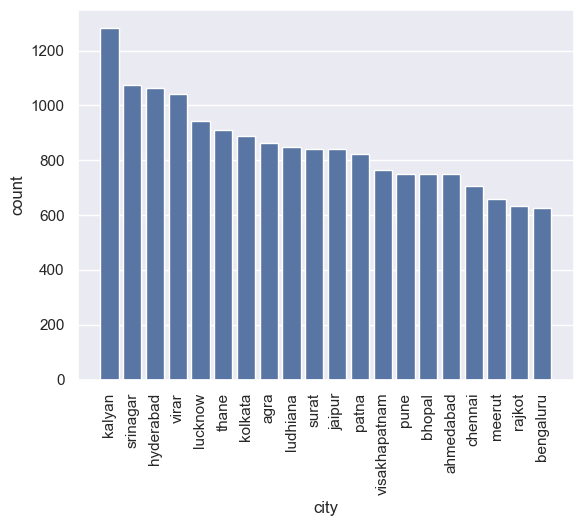

In [44]:
# lets create a simple bar chart of to 20 cities
import seaborn as sns

top_20_cities = city_counts.sort_values(by="count", ascending=False).head(20)
sns.set_theme(style="darkgrid")
plt = sns.barplot(
    data=top_20_cities, x="city", y="count")
plt.set_xticks(labels=top_20_cities["city"], ticks=range(top_20_cities.shape[0]))
plt.set_xticklabels(labels=top_20_cities["city"],rotation=90)
plt.plot(scalex=True)

* Interesting to note that a lot of cities from top 20 are from maharastra and from Mumbai/Pune area.
* Lets plot these clusters on map to get better visualization. 

In [54]:
import plotly.express as px

## lets prepare the data to plot on the map.
## step 1: lets group by lat,long and count the city
geo_data = updated_categories.groupby(["lat","long"], as_index=False)["city"].count()



fig = px.scatter_geo(geo_data, lat="lat", lon="long", size="city", title="Number of records per city", labels={"city": "Number of Instances"})
fig.update_layout(geo_scope = 'asia')
fig.update_geos(fitbounds="locations")
fig.show()
# # fig.write_image(Path(report_images_path, f"geo_mapping.webp"))

* So looks like the data is majorly from North western cities.
* Lets combine this data with depression data and see if there are any patterns. 

In [66]:
combined_data = pd.concat([updated_categories, y_train], axis=1)
combined_data.shape
# combined_data.groupby(["lat","long","city"], as_index=False)["depression"].count()

(22320, 14)

In [76]:
print(combined_data["lat"].isna().sum(),combined_data["long"].isna().sum())
invalid_city_ratio = (combined_data[combined_data['is_valid_city'] == 0].shape[0] / combined_data.shape[0]) * 100
print(f"Missing Cities : {invalid_city_ratio}")
print(combined_data.shape)

0 0
Missing Cities : 0.08512544802867383
(22320, 14)


In [77]:
fig = px.scatter_map(combined_data, lat="lat", lon="long",size="depression",title="Number of records per city")
# fig.update_layout(geo_scope = 'asia')
fig.update_geos(fitbounds="locations")
fig.show()


* The above maps are not giving us enough insight because we are using the same lat/long for cities. 
* We need to create a aggregated dataset which has latlong, city, number of instances, number of depressed instances, number of un depressed instances and its ratio.
* Plotting this data should give us some helpful insight.

In [106]:
combined_aggregation = combined_data.loc[combined_data["is_valid_city"] == 1].groupby(["lat", "long","city"],as_index=False).agg(
    total_instances=("city","count"),
    total_depression_count=("depression", "sum")
)
combined_aggregation["total_non_depression_count"] = combined_aggregation["total_instances"] - combined_aggregation["total_depression_count"] 
combined_aggregation["depression_ratio"] = combined_aggregation["total_depression_count"] / combined_aggregation["total_instances"]
print(combined_aggregation.shape)
combined_aggregation.head()

(32, 7)


,lat,long,city,total_instances,total_depression_count,total_non_depression_count,depression_ratio
0,12.971940,77.59369,bengaluru,625,382,243,0.611200
1,13.088375,80.27165,chennai,707,416,291,0.588402
2,13.400280,75.18341,nandini,1,0,1,0.000000
3,17.392845,78.47306,hyderabad,1063,703,360,0.661336
4,17.680090,83.20161,visakhapatnam,763,428,335,0.560944


In [107]:
fig = px.scatter_map(combined_aggregation, lat="lat", lon="long", size="total_instances",
                     color="depression_ratio", title="Depression Rations and Total Instances", labels={"city":"City"}, color_continuous_scale="Bluered")
fig.update_geos(fitbounds="locations")
fig.show()

* So visually we don't see any significant cluster,lets check the measures of central tendancy to identify any patterns. 

In [108]:
combined_aggregation["depression_ratio"].describe()

count    32.000000
mean      0.578338
std       0.133437
min       0.000000
25%       0.553478
50%       0.585017
75%       0.612908
max       1.000000
Name: depression_ratio, dtype: float64

In [109]:
fig = px.bar(combined_aggregation.sort_values(by="total_instances", ascending=False),x="city",y="depression_ratio", hover_data=["total_instances"])
fig.show()

* As suspected, more or less the ratio is same for all the cities. The locations where the value is 1, are mostly invalid cities or cities with 1 or 2 instances. 
* The city depression ratio has very less variance so it might not contribute to the ML training, but we'll experiment with the feature to confirm. 
* We'll create the following 2 new features,
    * `city_depression_ratio` which we'll map to each instance of dataset and will set it to the median value for in valid cities or any cities we can't verify. 
    * `cluster_similarity` we'll use KMeans and RBF Kernel to create n clusters and add correnponding `cluster_similarity` features to each instance of dataset. For invalid cities we'll be using `Nagpur` for similarity.

## Preprocessing Numerical Data

* In this section lets explore numerical data and create a list of preprocessing required.

In [41]:
X_train.head()

,gender,age,city,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,suicidal_thoughts,work_study_hours,financial_stress,family_history
0,Male,18.0,Jaipur,Student,4.0,0.0,6.02,1.0,0.0,'7-8 hours',Moderate,'Class 12',Yes,3.0,5.0,No
1,Male,25.0,Vadodara,Student,3.0,0.0,6.37,2.0,0.0,'7-8 hours',Moderate,B.Arch,No,9.0,1.0,Yes
2,Male,30.0,Ahmedabad,Student,3.0,0.0,9.24,2.0,0.0,'7-8 hours',Unhealthy,M.Ed,Yes,5.0,5.0,Yes
3,Male,34.0,Bhopal,Student,3.0,0.0,7.37,5.0,0.0,'7-8 hours',Moderate,B.Com,Yes,12.0,3.0,No
4,Male,25.0,Patna,Student,3.0,0.0,7.47,4.0,0.0,'5-6 hours',Unhealthy,B.Com,No,11.0,5.0,No


In [42]:
X_train.select_dtypes(include=["float64"])

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work_study_hours,financial_stress
0,18.0,4.0,0.0,6.02,1.0,0.0,3.0,5.0
1,25.0,3.0,0.0,6.37,2.0,0.0,9.0,1.0
2,30.0,3.0,0.0,9.24,2.0,0.0,5.0,5.0
3,34.0,3.0,0.0,7.37,5.0,0.0,12.0,3.0
4,25.0,3.0,0.0,7.47,4.0,0.0,11.0,5.0
...,...,...,...,...,...,...,...,...
22315,27.0,5.0,0.0,9.74,3.0,0.0,5.0,4.0
22316,34.0,5.0,0.0,6.39,3.0,0.0,8.0,3.0
22317,33.0,3.0,0.0,5.24,1.0,0.0,8.0,4.0
22318,29.0,4.0,0.0,7.15,2.0,0.0,1.0,3.0


In [43]:
numerical_data = X_train.select_dtypes(include=["float64"])
numerical_data

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work_study_hours,financial_stress
0,18.0,4.0,0.0,6.02,1.0,0.0,3.0,5.0
1,25.0,3.0,0.0,6.37,2.0,0.0,9.0,1.0
2,30.0,3.0,0.0,9.24,2.0,0.0,5.0,5.0
3,34.0,3.0,0.0,7.37,5.0,0.0,12.0,3.0
4,25.0,3.0,0.0,7.47,4.0,0.0,11.0,5.0
...,...,...,...,...,...,...,...,...
22315,27.0,5.0,0.0,9.74,3.0,0.0,5.0,4.0
22316,34.0,5.0,0.0,6.39,3.0,0.0,8.0,3.0
22317,33.0,3.0,0.0,5.24,1.0,0.0,8.0,4.0
22318,29.0,4.0,0.0,7.15,2.0,0.0,1.0,3.0


In [44]:
numerical_data.describe()

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work_study_hours,financial_stress
count,22320.000000,22320.000000,22320.000000,22320.000000,22320.000000,22320.000000,22320.000000,22318.000000
mean,25.840771,3.144668,0.000314,7.661163,2.941622,0.000627,7.161514,3.135138
std,4.905634,1.377913,0.036045,1.470131,1.360654,0.041258,3.705939,1.436166
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000
50%,26.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000
75%,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000
max,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000


* Almost all of the columns have similar `mean` and `median` so data is not skewed
* The mean of `work_pressure` and `job_satisfaction` tells me that majority of the values are 0 or close to 0.  I think it would be safe to drop these columns since there is no variance and will not contribute to the ML learning. 
* `financial_stress` has 2 missing values, I think we can impute the data with mean or median. 
* Other than `age`, `cgpa` and `work_study_hours` rest of the columns are satisfaction ratings and I think we should create bins for these columns instead of using the discreet values. Lets check the visualizations and value counts. 

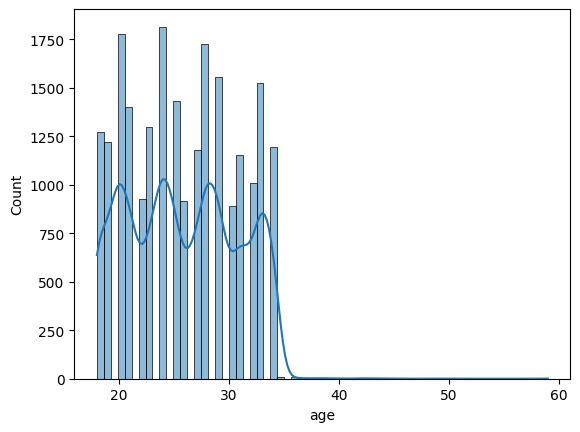

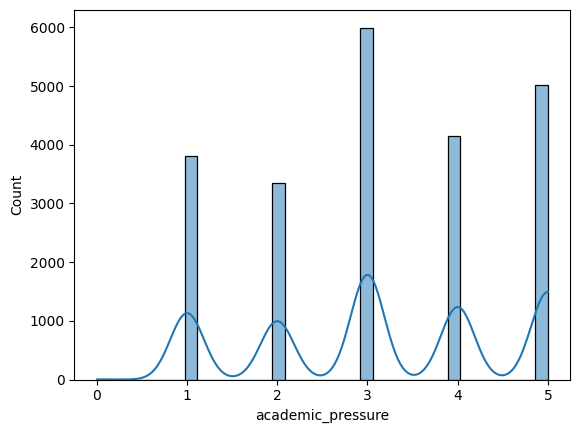

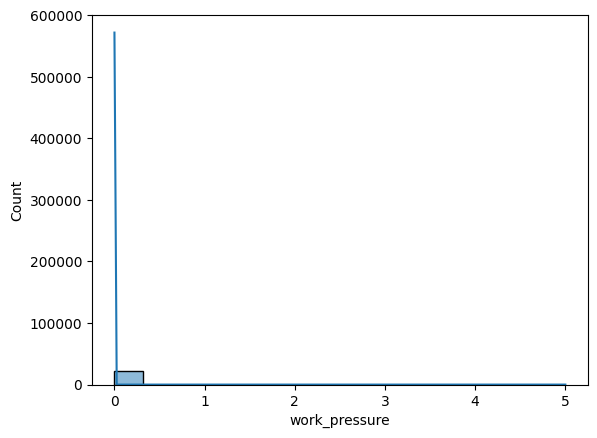

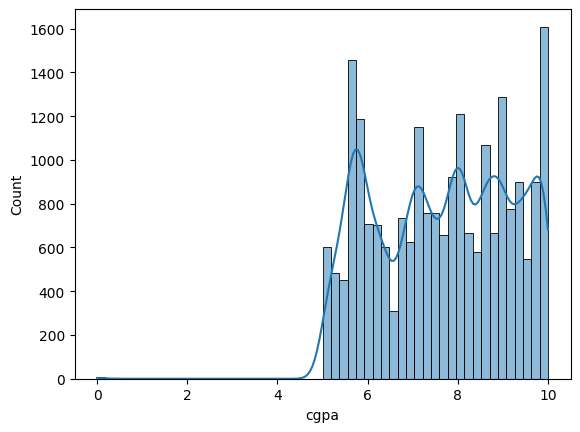

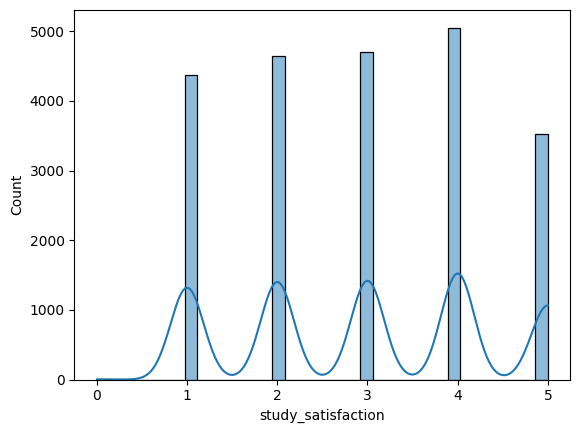

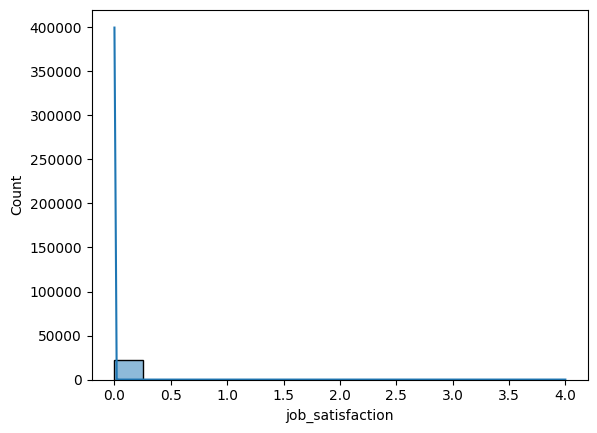

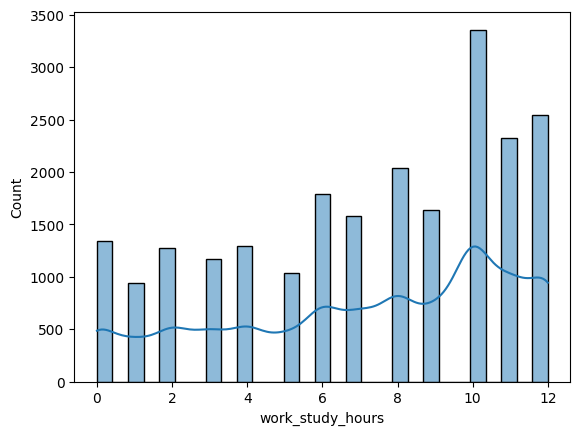

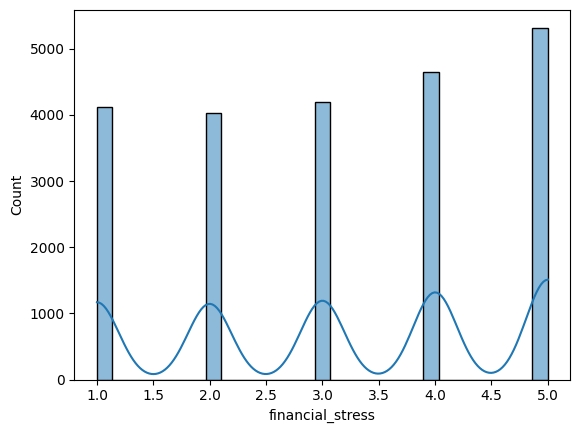

In [45]:
import seaborn as sns
import matplotlib.pyplot as pyt


for col in numerical_data.columns:
    pyt.figure()
    sns.histplot(numerical_data[col], kde=True)

* The visualizations confirm our earlier assumptions,
    * Safe to drop job satisfaction and work pressure columns as they add no values. 
* We will converting `age`, `cgpa` and `work_study_hours` into categorical bins
* We will scale and use `academic_pressure`, `study_satisfaction` and `finalcial_stress` as it is. 

#### Default Changes
* The training data doesn't seem to have any null or missing value, but to make sure test or production data doesn't break, lets add default median imputer for all the columns. 
* Since our data is not skewed using median shouldn't affect the overall variance. 


In [46]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer

default_num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

default_num_pipeline.set_output(transform="pandas")

Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

### Preprocessing Age

In [47]:
numerical_data["age"].describe()

count    22320.000000
mean        25.840771
std          4.905634
min         18.000000
25%         21.000000
50%         26.000000
75%         30.000000
max         59.000000
Name: age, dtype: float64

In [48]:
numerical_data["age"].isnull().sum()

np.int64(0)

* Lets create 5 year bins from 18 to 30 and last bin would greater than 30.
    * 18_to_23
    * 23_to_28
    * 28_to_33
    * gte_33
* Then we'll encode this with parameter to choose between onehot or ordinal


In [49]:
# helper function to map and create age bins
def map_age_bins_feature_names(function_transformer, feature_names_in):
    features_out = feature_names_in.tolist()
    features_out.extend(["age_range"])
    return features_out


def map_age_bins_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("map_age_bins_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    # default value
    df_copy["age_range"] = "gte_33"
    df_copy.loc[df_copy["age"].between(
        18, 23, "left"), "age_range"] = "18_to_23"
    df_copy.loc[df_copy["age"].between(
        23, 28, "left"), "age_range"] = "23_to_28"
    df_copy.loc[df_copy["age"].between(
        28, 33, "left"), "age_range"] = "28_to_33"
    return df_copy


map_age_bins = FunctionTransformer(
    map_age_bins_fn, feature_names_out=map_age_bins_feature_names)


def make_age_encoder_fn(encoding="onehot"):
    encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore")

    if encoding == "ordinal":
        encoder = OrdinalEncoder(categories=[[
            "18_to_23", "23_to_28", "28_to_33", "gte_33"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)

    return ColumnTransformer(
        [("encode_age_range", encoder, ["age_range"])]
    )


age_pipeline = Pipeline(
    [("default_num_pipeline", default_num_pipeline),
     ("map_age_bins", map_age_bins),
     ("encode_age", make_age_encoder_fn(encoding="onehot"))]
)

preprocess_age = ColumnTransformer(
    [
        ("age_pipeline", age_pipeline, ["age"]),
    ]
)


temp = preprocess_age.fit_transform(X_train)
preprocess_age.get_feature_names_out()

array(['age_pipeline__encode_age_range__age_range_18_to_23',
       'age_pipeline__encode_age_range__age_range_23_to_28',
       'age_pipeline__encode_age_range__age_range_28_to_33',
       'age_pipeline__encode_age_range__age_range_gte_33'], dtype=object)

In [50]:
temp

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], shape=(22320, 4))

* lets update numerical data with bins for future use

In [51]:
numerical_data = map_age_bins_fn(numerical_data)

### Preprocesing CGPA

In [52]:
numerical_data["cgpa"].describe()

count    22320.000000
mean         7.661163
std          1.470131
min          0.000000
25%          6.290000
50%          7.770000
75%          8.920000
max         10.000000
Name: cgpa, dtype: float64

* For CGPA lets create the following bins
    * Less than 4 "lt_4"
    * 4 to 7 "4_to_7"
    * 7 and above "gt_7"

In [53]:
# helper function to map and create cgpa bins
def map_cgpa_bins_feature_names(function_transformer, feature_names_in):
    features_out = feature_names_in.tolist()
    features_out.extend(["cgpa_range"])
    return features_out


def map_cgpa_bins_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("map_cgpa_bins_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    # default value
    df_copy["cgpa_range"] = "gte_7"
    df_copy.loc[df_copy["cgpa"].between(
        0, 4, "left"), "cgpa_range"] = "lt_4"
    df_copy.loc[df_copy["cgpa"].between(
        4, 7, "left"), "cgpa_range"] = "4_to_7"
    return df_copy


map_cgpa_bins = FunctionTransformer(
    map_cgpa_bins_fn, feature_names_out=map_cgpa_bins_feature_names)


def make_cgpa_encoder_fn(encoding="onehot"):
    encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore")

    if encoding == "ordinal":
        encoder = OrdinalEncoder(categories=[[
            "lt_4", "4_to_7", "gte_7"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)

    return ColumnTransformer(
        [("encode_cgpa_range", encoder, ["cgpa_range"])]
    )


cgpa_pipeline = Pipeline(
    [("default_num_pipeline", default_num_pipeline),
     ("map_cgpa_bins", map_cgpa_bins),
     ("encode_cgpa", make_cgpa_encoder_fn(encoding="onehot"))]
)

preprocess_cgpa = ColumnTransformer(
    [
        ("cgpa_pipeline", cgpa_pipeline, ["cgpa"]),
    ]
)


temp = preprocess_cgpa.fit_transform(X_train)
preprocess_cgpa.get_feature_names_out()

array(['cgpa_pipeline__encode_cgpa_range__cgpa_range_4_to_7',
       'cgpa_pipeline__encode_cgpa_range__cgpa_range_gte_7',
       'cgpa_pipeline__encode_cgpa_range__cgpa_range_lt_4'], dtype=object)

In [54]:
temp

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], shape=(22320, 3))

In [55]:
## updating numerical data with cgpa bins
numerical_data = map_cgpa_bins_fn(numerical_data)
numerical_data.head()

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work_study_hours,financial_stress,age_range,cgpa_range
0,18.0,4.0,0.0,6.02,1.0,0.0,3.0,5.0,18_to_23,4_to_7
1,25.0,3.0,0.0,6.37,2.0,0.0,9.0,1.0,23_to_28,4_to_7
2,30.0,3.0,0.0,9.24,2.0,0.0,5.0,5.0,28_to_33,gte_7
3,34.0,3.0,0.0,7.37,5.0,0.0,12.0,3.0,gte_33,gte_7
4,25.0,3.0,0.0,7.47,4.0,0.0,11.0,5.0,23_to_28,gte_7


### Preprocessing Work Study Hours

In [56]:
numerical_data["work_study_hours"].describe()

count    22320.000000
mean         7.161514
std          3.705939
min          0.000000
25%          4.000000
50%          8.000000
75%         10.000000
max         12.000000
Name: work_study_hours, dtype: float64

In [57]:
numerical_data["work_study_hours"].value_counts()

work_study_hours
10.0    3358
12.0    2543
11.0    2325
8.0     2036
6.0     1792
9.0     1634
7.0     1584
0.0     1343
4.0     1291
2.0     1272
3.0     1167
5.0     1039
1.0      936
Name: count, dtype: int64

* We'll create following bins for work_study_hours
    * Less than 4 hours - lt_4
    * 4 to 8 hours - 4_to_8
    * greater than or equal to 8 hours - gte_8

In [58]:
# helper function to map and create hours bins
def map_hours_bins_feature_names(function_transformer, feature_names_in):
    features_out = feature_names_in.tolist()
    features_out.extend(["hours_range"])
    return features_out

def map_hours_bins_fn(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("map_hours_bins_fn : Input must be a pandas DataFrame")
    df_copy = df.copy()
    # default value
    df_copy["hours_range"] = "gte_8"
    df_copy.loc[df_copy["work_study_hours"].between(
        0, 4, "left"), "hours_range"] = "lt_4"
    df_copy.loc[df_copy["work_study_hours"].between(
        4, 8, "left"), "hours_range"] = "4_to_8"
    return df_copy


map_hours_bins = FunctionTransformer(
    map_hours_bins_fn, feature_names_out=map_hours_bins_feature_names)


def make_hours_encoder_fn(encoding="onehot"):
    encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore")

    if encoding == "ordinal":
        encoder = OrdinalEncoder(categories=[[
            "lt_4", "4_to_8", "gte_8"
        ]], handle_unknown="use_encoded_value", unknown_value=-1)

    return ColumnTransformer(
        [("encode_hours_range", encoder, ["hours_range"])]
    )


hours_pipeline = Pipeline(
    [("default_num_pipeline", default_num_pipeline),
     ("map_hours_bins", map_hours_bins),
     ("encode_hours", make_hours_encoder_fn(encoding="onehot"))]
)

preprocess_hours = ColumnTransformer(
    [
        ("hours_pipeline", hours_pipeline, ["work_study_hours"]),
    ]
)


temp = preprocess_hours.fit_transform(X_train)
preprocess_hours.get_feature_names_out()

array(['hours_pipeline__encode_hours_range__hours_range_4_to_8',
       'hours_pipeline__encode_hours_range__hours_range_gte_8',
       'hours_pipeline__encode_hours_range__hours_range_lt_4'],
      dtype=object)

In [59]:
numerical_data = map_hours_bins_fn(numerical_data)
numerical_data.head()

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work_study_hours,financial_stress,age_range,cgpa_range,hours_range
0,18.0,4.0,0.0,6.02,1.0,0.0,3.0,5.0,18_to_23,4_to_7,lt_4
1,25.0,3.0,0.0,6.37,2.0,0.0,9.0,1.0,23_to_28,4_to_7,gte_8
2,30.0,3.0,0.0,9.24,2.0,0.0,5.0,5.0,28_to_33,gte_7,4_to_8
3,34.0,3.0,0.0,7.37,5.0,0.0,12.0,3.0,gte_33,gte_7,gte_8
4,25.0,3.0,0.0,7.47,4.0,0.0,11.0,5.0,23_to_28,gte_7,gte_8


### Preprocessing Rating Columns
* `academic_pressure`, `study_satisfaction` and `financial_stress` are ratings form 1 to 5, so we can group the preprocessing of these columns togather. 

In [60]:
numerical_data["academic_pressure"].value_counts()

academic_pressure
3.0    5996
5.0    5021
4.0    4152
1.0    3800
2.0    3344
0.0       7
Name: count, dtype: int64

In [61]:
numerical_data["academic_pressure"].describe()

count    22320.000000
mean         3.144668
std          1.377913
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: academic_pressure, dtype: float64

In [62]:
numerical_data["study_satisfaction"].value_counts(
)

study_satisfaction
4.0    5053
3.0    4705
2.0    4648
1.0    4374
5.0    3532
0.0       8
Name: count, dtype: int64

In [63]:
numerical_data["study_satisfaction"].describe()

count    22320.000000
mean         2.941622
std          1.360654
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: study_satisfaction, dtype: float64

In [64]:
numerical_data["financial_stress"].value_counts()

financial_stress
5.0    5321
4.0    4645
3.0    4200
1.0    4119
2.0    4033
Name: count, dtype: int64

In [65]:
numerical_data["financial_stress"].describe()

count    22318.000000
mean         3.135138
std          1.436166
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: financial_stress, dtype: float64

* For academic pressure, we'll simply impute the values and scale them.
* We can actually combine `academic_pressure`, `study_satisfaction` and `financial_pressure` into a single pipeline, since the transformers needed for all three are same. 

In [66]:
rating_columns_pipeline = Pipeline([
    ("default_num_pipeline", default_num_pipeline),
    ("scale_rating_columns", StandardScaler())
])

rating_columns_pipeline.set_output(transform="pandas")

preprocess_rating_coluns = ColumnTransformer([
    ("ratings_column_pipeline", rating_columns_pipeline, ["academic_pressure","study_satisfaction","financial_stress"])    
])

temp = preprocess_rating_coluns.fit_transform(X_train)
preprocess_rating_coluns.get_feature_names_out()

array(['ratings_column_pipeline__academic_pressure',
       'ratings_column_pipeline__study_satisfaction',
       'ratings_column_pipeline__financial_stress'], dtype=object)

In [67]:
temp

array([[ 0.62075795, -1.42700892,  1.29859598],
       [-0.10499332, -0.69205175, -1.48678382],
       [-0.10499332, -0.69205175,  1.29859598],
       ...,
       [-0.10499332, -1.42700892,  0.60225103],
       [ 0.62075795, -0.69205175, -0.09409392],
       [ 0.62075795,  1.51281978,  0.60225103]], shape=(22320, 3))

### Dropping Work pressure and job satisfaction

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        input_features = (
            input_features if input_features is not None
            else getattr(self, "feature_names_in_", None)
        )
        if input_features is None:
            raise ValueError("Input features not available for get_feature_names_out")

        return [col for col in input_features if col not in self.columns_to_drop]

# Use inside your top-level pipeline
drop_useless_cols = DropColumns(columns_to_drop=["work_pressure", "job_satisfaction"])

drop_column_pipeline = Pipeline([
    ("drop_useless", drop_useless_cols)
])

# temp = drop_column_pipeline.fit_transform(X_train)
# temp



## Combining Pipelines

* Lets combine the pipelines and create 2 column transformers one for categories and one for numerical data. 

In [69]:
preprocess_categorical_data = ColumnTransformer(
    [("preprocess_gender", gender_pipeline, ["gender"]),
     ("preprocess_profession", profession_pipeline, ["profession"]),
        ("sleep_duration_pipeline", make_sleep_duration_pipeline_fn(
            encoding="ordinal"), ["sleep_duration"]),
        ("dietary_habits_pipeline", make_dietary_habits_pipeline_fn(
            encoding="onehot"), ["dietary_habits"]),
        ("degree_pipeline", degree_pipeline, ["degree"]),
        (
        "suicidal_thoughts_pipeline", suicidal_thoughts_pipeline, [
            "suicidal_thoughts"]
    ),
        (
        "family_history_pipeline", family_history_pipeline, ["family_history"]
    ),
        ("city_pipeline", city_pipeline, ["city"])
    ]
)

preprocess_numerical_data = ColumnTransformer([
        ("age_pipeline", age_pipeline, ["age"]),
        ("cgpa_pipeline", cgpa_pipeline, ["cgpa"]),
        ("hours_pipeline", hours_pipeline, ["work_study_hours"]),
        ("ratings_column_pipeline", rating_columns_pipeline, [
         "academic_pressure", "study_satisfaction", "financial_stress"])
    ])

processed_categorical_data_df = pd.DataFrame(preprocess_categorical_data.fit_transform(X_train),columns=preprocess_categorical_data.get_feature_names_out())
processed_categorical_data_df.head()

processed_numerical_data_df = pd.DataFrame(preprocess_numerical_data.fit_transform(X_train),columns=preprocess_numerical_data.get_feature_names_out())
processed_numerical_data_df.head()

,age_pipeline__encode_age_range__age_range_18_to_23,age_pipeline__encode_age_range__age_range_23_to_28,age_pipeline__encode_age_range__age_range_28_to_33,age_pipeline__encode_age_range__age_range_gte_33,cgpa_pipeline__encode_cgpa_range__cgpa_range_4_to_7,cgpa_pipeline__encode_cgpa_range__cgpa_range_gte_7,cgpa_pipeline__encode_cgpa_range__cgpa_range_lt_4,hours_pipeline__encode_hours_range__hours_range_4_to_8,hours_pipeline__encode_hours_range__hours_range_gte_8,hours_pipeline__encode_hours_range__hours_range_lt_4,ratings_column_pipeline__academic_pressure,ratings_column_pipeline__study_satisfaction,ratings_column_pipeline__financial_stress
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.620758,-1.427009,1.298596
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.104993,-0.692052,-1.486784
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.104993,-0.692052,1.298596
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.104993,1.512820,-0.094094
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.104993,0.777863,1.298596


* 

In [71]:
processed_categorical_data_df.head()

,preprocess_gender__gender_female,preprocess_gender__gender_male,preprocess_profession__profession_student,preprocess_profession__profession_working,sleep_duration_pipeline__sleep_duration,dietary_habits_pipeline__dietary_habits_healthy,dietary_habits_pipeline__dietary_habits_moderate,dietary_habits_pipeline__dietary_habits_unhealthy,degree_pipeline__encode_degree_field__degree_field_architecture,degree_pipeline__encode_degree_field__degree_field_arts,...,degree_pipeline__encode_degree_level__degree_level_master,degree_pipeline__encode_degree_level__degree_level_unknown,suicidal_thoughts_pipeline__suicidal_thoughts_no,suicidal_thoughts_pipeline__suicidal_thoughts_yes,family_history_pipeline__family_history_no,family_history_pipeline__family_history_yes,city_pipeline__city,city_pipeline__is_valid_city,city_pipeline__lat,city_pipeline__long
0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,jaipur,1,24.244465,83.044083
1,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,vadodara,1,22.239705,73.16406
2,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,ahmedabad,1,25.95781,75.79308
3,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,bhopal,1,24.608358,78.274762
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,patna,1,24.782727,81.02966
